In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
savedir = '/das/work/p19/p19262/Claudio/Reduced_data/'
os.makedirs(savedir, exist_ok=True)
print (savedir)

/das/work/p19/p19262/Claudio/Reduced_data/


## First load a few images to identify ROIs and check threshold

In [2]:
pgroup='p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [4]:
nshots = 100
threshold_low = 2
threshold_high = 10

######################################################################

total_image, total_image_thr, total_for_hist, total_for_hist_thr = \
XES_static_full(fc.selected, pgroup, threshold_low, threshold_high, nshots)

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_011280.JF02T09V02.res.h5
jungfrau file: 11:44 04.12.2021
pedestal file: 09:32 04.12.2021
    mtime difference: 2:12:44.982375
Loaded 100 images
It took 4.96 seconds to process this file


<IPython.core.display.Javascript object>


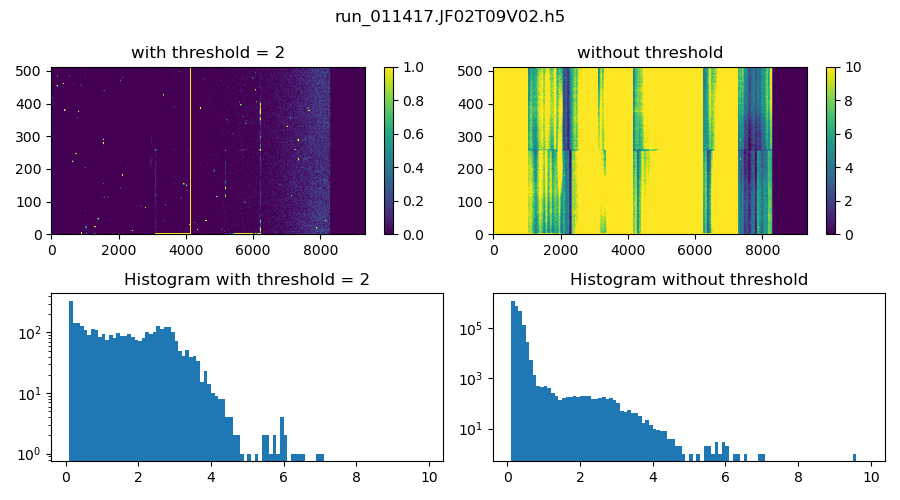

In [5]:
plt.figure(figsize=(9,5))
plt.suptitle(fc.selected_filename)
plt.subplots_adjust(wspace=0.5)

plt.subplot(221)
plt.imshow(total_image_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()

plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_for_hist_thr.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.subplot(222)
plt.imshow(total_image, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.title("without threshold")
plt.colorbar()

plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total_for_hist.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.tight_layout()
plt.show()

## Next cells for a single file, ONLY JF file!

In [2]:
pgroup='p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
roi1 = (2900, 3100, 180, 240) #signal CRY2 low
roi2 = (2950, 3100, 260, 320) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

######################################################################################

spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
XES_PumpProbe_4ROIs(fc.selected, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots)

Processing file run_011417.JF02T09V02.h5
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_011280.JF02T09V02.res.h5
jungfrau file: 11:44 04.12.2021
pedestal file: 09:32 04.12.2021
    mtime difference: 2:12:44.982375
Total images = 5001, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 3000, None)
Load batch = slice(3000, 4000, None)
Load batch = slice(4000, 5000, None)
Load batch = slice(5000, 5001, None)
It took 23.87 seconds to process this file


<IPython.core.display.Javascript object>


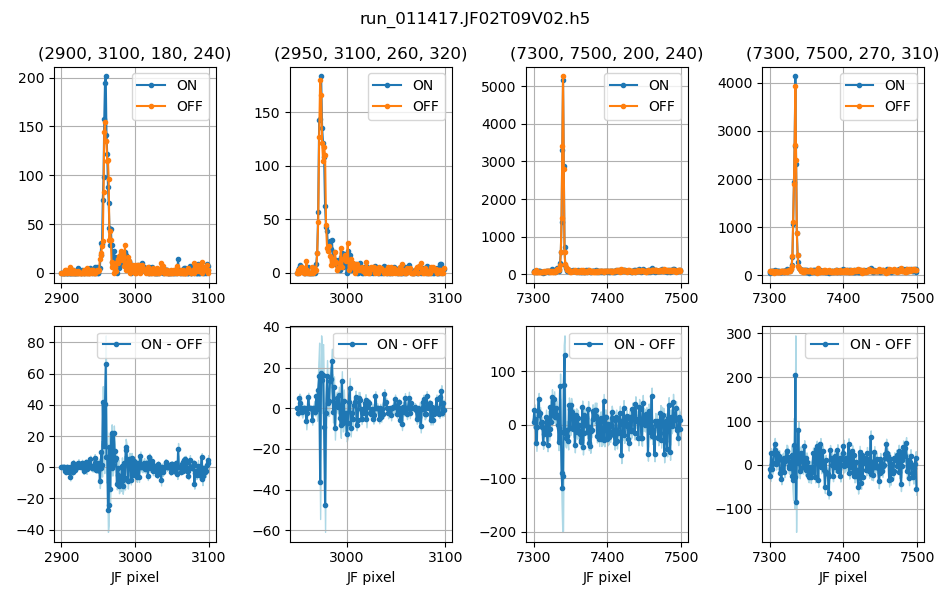

In [10]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle(fc.selected_filename)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

## Now with Energy calibration 

In [11]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

<IPython.core.display.Javascript object>


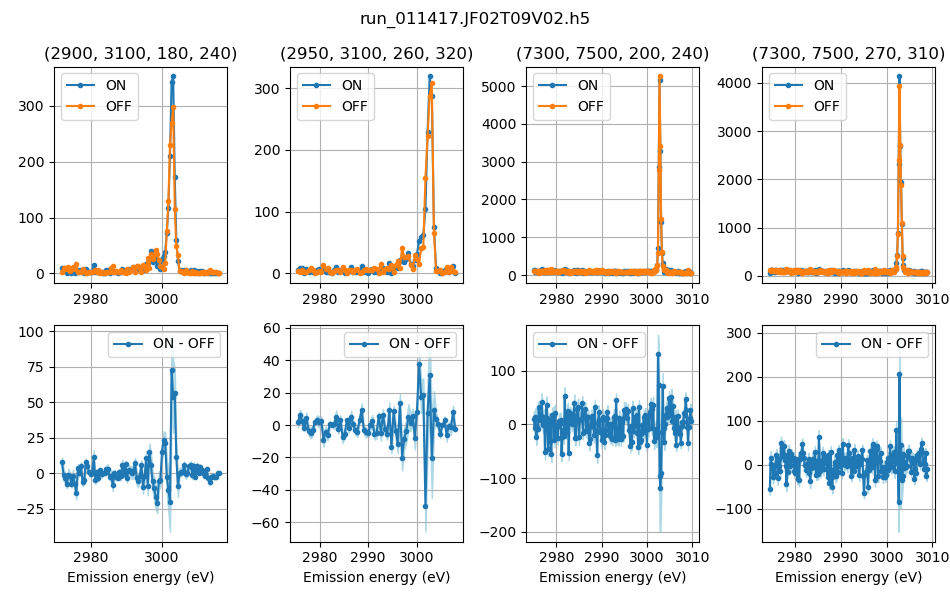

In [14]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle(fc.selected_filename)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('Emission energy (eV)')
    

plt.tight_layout()

## Next cells for a summing up identical file, ONLY JF file!

In [15]:
datalist = []
for file in glob('/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1/*JF*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[:4]
print (len(patch))
patch

4


['/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1/run_011417.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1/run_011418.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1/run_011419.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1/run_011420.JF02T09V02.h5']

In [16]:
roi1 = (2900, 3100, 180, 240) #signal CRY2 low
roi2 = (2950, 3100, 260, 320) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

######################################################################################
from alvra_tools import clock
clock_int = clock.Clock()

spectrum_roi1_ON_all = []
spectrum_roi2_ON_all = []
spectrum_roi3_ON_all = []
spectrum_roi4_ON_all = []
spectrum_roi1_OFF_all = []
spectrum_roi2_OFF_all = []
spectrum_roi3_OFF_all = []
spectrum_roi4_OFF_all = []

for JF_single_file in patch:
    
    spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
    spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
    XES_PumpProbe_4ROIs(fc.selected, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots)
    
    spectrum_roi1_ON_all.append(spectrum_ON_roi1)
    spectrum_roi2_ON_all.append(spectrum_ON_roi2)
    spectrum_roi3_ON_all.append(spectrum_ON_roi3)
    spectrum_roi4_ON_all.append(spectrum_ON_roi4)
    spectrum_roi1_OFF_all.append(spectrum_OFF_roi1)
    spectrum_roi2_OFF_all.append(spectrum_OFF_roi2)
    spectrum_roi3_OFF_all.append(spectrum_OFF_roi3)
    spectrum_roi4_OFF_all.append(spectrum_OFF_roi4)
    
    clear_output(wait=True)
    print ("It took", clock_int.tick(), "seconds to process this file")

spectrum_roi1_ON_all = np.asarray(spectrum_roi1_ON_all)
spectrum_roi2_ON_all = np.asarray(spectrum_roi2_ON_all)
spectrum_roi3_ON_all = np.asarray(spectrum_roi3_ON_all)
spectrum_roi4_ON_all = np.asarray(spectrum_roi4_ON_all)
spectrum_roi1_OFF_all = np.asarray(spectrum_roi1_OFF_all)
spectrum_roi2_OFF_all = np.asarray(spectrum_roi2_OFF_all)
spectrum_roi3_OFF_all = np.asarray(spectrum_roi3_OFF_all)
spectrum_roi4_OFF_all = np.asarray(spectrum_roi4_OFF_all)

print ("It took {} seconds to process {} files".format(clock_int.tock(), len(patch)))

It took 23.76 seconds to process this file
It took 92.45 seconds to process 4 files


<IPython.core.display.Javascript object>


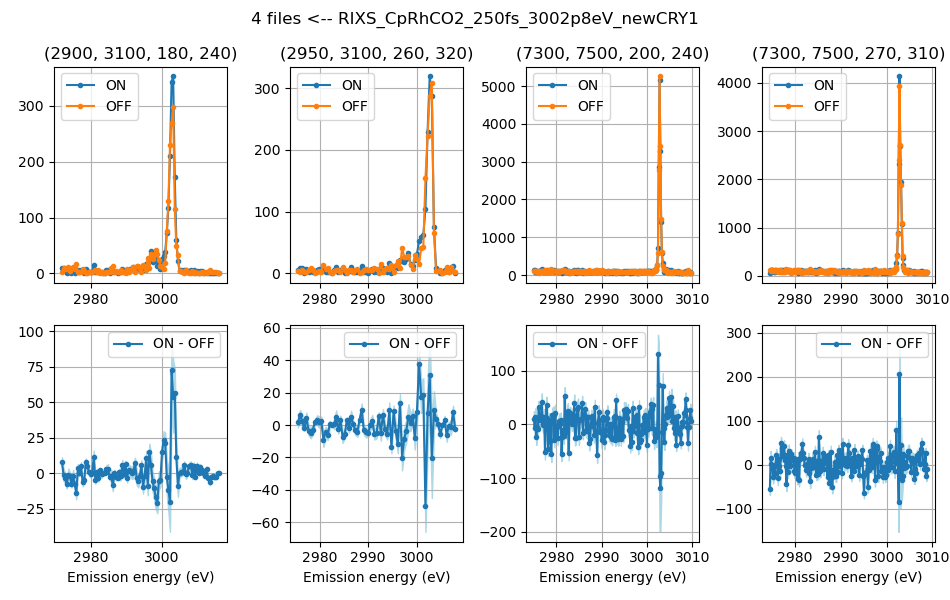

In [20]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_ON_roi1 = np.mean(spectrum_roi1_ON_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_roi2_ON_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_roi3_ON_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_roi4_ON_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_roi1_OFF_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_roi2_OFF_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_roi3_OFF_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_roi4_OFF_all, axis = 0)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

## Now with Energy calibration 

<IPython.core.display.Javascript object>


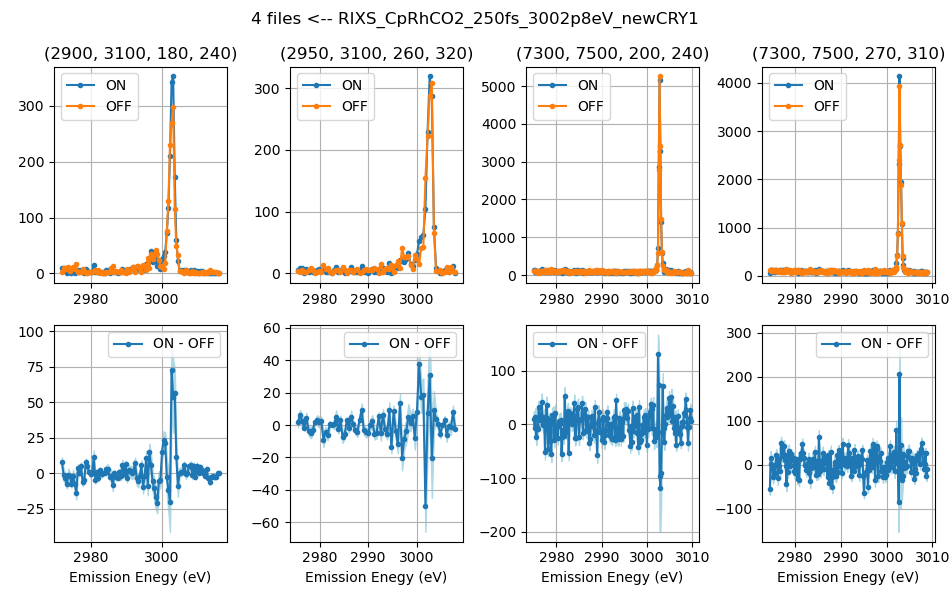

In [22]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_ON_roi1 = np.mean(spectrum_roi1_ON_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_roi2_ON_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_roi3_ON_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_roi4_ON_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_roi1_OFF_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_roi2_OFF_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_roi3_OFF_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_roi4_OFF_all, axis = 0)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('Emission Enegy (eV)')
    

plt.tight_layout()

In [ ]:
outdir = '/das/work/p18/p18442/Exported_data/'
filename_h5 = outdir + scan_name + "_export.h5" 
with h5py.File(filename_h5, "w") as file2write:
    file2write.create_dataset("energy_eV", data = Energy_eV)
    file2write.create_dataset("roi1", data = roi1)
    file2write.create_dataset("pump_roi1", data = RIXS_pumped_roi1)
    file2write.create_dataset("unpump_roi1", data = RIXS_unpumped_roi1)
    file2write.create_dataset("transient_roi1", data = RIXS_transient_roi1)
    file2write.create_dataset("roi2", data = roi2)
    file2write.create_dataset("pump_roi2", data = RIXS_pumped_roi2)
    file2write.create_dataset("unpump_roi2", data = RIXS_unpumped_roi2)
    file2write.create_dataset("transient_roi2", data = RIXS_transient_roi2)

print(filename_h5)

In [ ]:
scan_name_load = 'RuBpy_RIXS_6'

##########################################################

outdir = '/das/work/p18/p18442/Exported_data/'
fn = outdir + scan_name_load + "_export.h5" 
print (fn)
with h5py.File(fn, "r") as file2open:
    Energy_eV = file2open['energy_eV'][:]
    roi1 = file2open['roi1'][:]
    RIXS_pumped_roi1 = file2open['pump_roi1'][:]
    RIXS_unpumped_roi1 = file2open['unpump_roi1'][:]
    RIXS_transient_roi1 = file2open['transient_roi1'][:]
    roi2 = file2open['roi2'][:]
    RIXS_pumped_roi2 = file2open['pump_roi2'][:]
    RIXS_unpumped_roi2 = file2open['unpump_roi2'][:]
    RIXS_transient_roi2 = file2open['transient_roi2'][:]

<IPython.core.display.Javascript object>


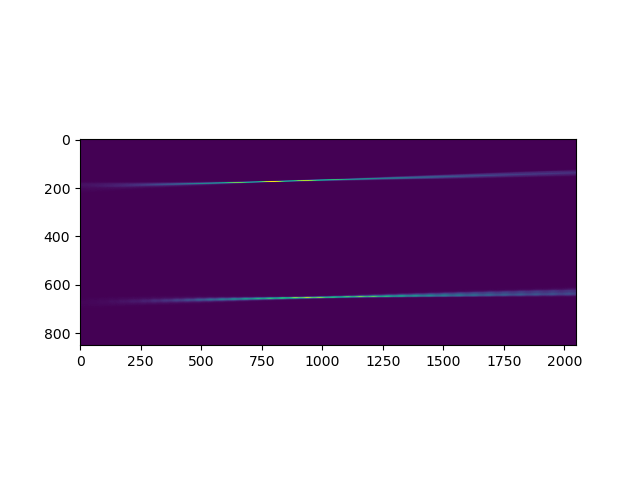

In [7]:
with SFDataFiles("/sf/alvra/data/p18938/raw/scan_data/SiN_timing_NOPA_shortX_loop3_000/run_014886.CAMERAS.h5") as sfd:
    ch = sfd['SARES11-SPEC125-M2:FPICTURE']
    img = ch.data[0]

plt.imshow(img)